In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [39]:
import tensorflow as tf

## getting data ready

In [4]:
import preprocessing
preprocessing._VERSION = 'data_v4'

def preprocess_features(features):
    # features:
    #   crossing_angle [-20, 20]
    #   dip_angle [-60, 60]
    #   drift_length [35, 290]
    #   pad_coordinate [40-something, 40-something]
    bin_fractions = features[:, 2:4] % 1
    features = (features[:, :3] - np.array([[0.0, 0.0, 162.5]])) / np.array([[20.0, 60.0, 127.5]])
    return np.concatenate([features, bin_fractions], axis=-1)

In [5]:
pad_range = (-3, 5)
time_range = (-7, 9)
data, features = preprocessing.read_csv_2d(
    filename='digits.csv', pad_range=pad_range, time_range=time_range
)

In [6]:
data.shape, features.shape

((20000, 8, 16), (20000, 4))

In [7]:
data_scaled = np.log10(1 + data).astype('float32')
features_processed = preprocess_features(features).astype('float32')
data_train, data_test, features_train, features_test = train_test_split(data_scaled, features_processed, test_size=0.25, random_state=42)

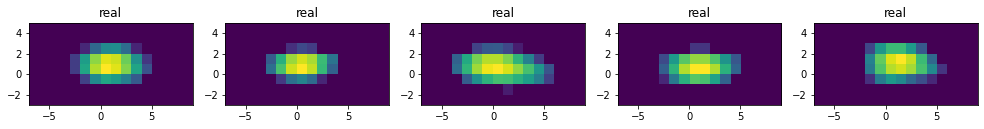

In [7]:
plt.figure(figsize=(17, 5))
for i in range(5):
  plt.subplot(2, 5, i + 1 + 5)
  plt.imshow(data_test[i,::-1], extent=(*time_range, *pad_range))
  plt.title('real')
plt.show()

## training

In [48]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [51]:
n_classes = 10
in_channels = 3
out_channels = 32


def new_block(in_channels, out_channels, kernel_size=3, padding=1, p=0.2):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels,kernel_size=kernel_size, padding=padding),
        nn.ELU(),
        nn.Dropout(p=p)
    )

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder1 = nn.Sequential(                        #     bs  f   h  w
            new_block(in_channels=6, out_channels=16),       # -> [bs, 16, 8, 16]
            new_block(in_channels=16, out_channels=16),      # -> [bs, 16, 8, 16]
        )

        self.encoder2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(2,2), stride=(2, 2)), #  -> [bs, 16, 8, 8]
            new_block(in_channels=16, out_channels=32),      # -> [bs, 32, 8, 8]
            new_block(in_channels=32, out_channels=32),      # -> [bs, 32, 8, 8]
            nn.MaxPool2d(kernel_size=(2,2), stride=(2, 2)),  # -> [bs, 32, 4, 4]
            new_block(in_channels=32, out_channels=64, padding=0),          # -> [bs, 64, 2, 2]
            new_block(in_channels=64, out_channels=64, kernel_size=2, padding=0) # -> [bs, 64, 1, 1]
        )

        self.linear = nn.Sequential(
            nn.Linear(in_features=69, out_features=128),
            nn.ELU(),
            nn.Linear(in_features=128, out_features=1)
        )

    def forward(self, features, image):  # features [bs, 5]  image [bs, 8, 16]
        bs, h, w = image.shape
        _, k = features.shape
        in_image = image.reshape((bs, 1, h, w))
        in_features = features.reshape((bs, k, 1, 1))
        in_features = torch.tile(in_features, (1, 1, h, w)) # -> features [bs, k, h, w]
        out = torch.cat((in_features, in_image), dim=1) # -> [bs, k+1, h, w]
        out = self.encoder1(out)
        out = F.pad(out, (0, 0, h//2, h//2))
        out = self.encoder2(out)
        out = out.squeeze()
        out = torch.cat((features, out), dim=1) # -> [bs, 69]
        out = self.linear(out)
        return out


class CustomActivation(nn.Module):  
    def __init__(self):
        super().__init__()

    def forward(self, x):
      shift = 0.01
      val = np.log10(2)
      v0 = np.log10(2) / 10
      return torch.where(
          x > shift, 
          val + x - shift,
          v0 + nn.ELU(alpha=(v0 * shift / (val - v0)))(x) * (val - v0) / shift
      )


class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(        #     [bs  n]
            nn.Linear(in_features=37, out_features=32),
            nn.ELU(),
            nn.Linear(in_features=32, out_features=64),
            nn.ELU(),
            nn.Linear(in_features=64, out_features=64),
            nn.ELU(),
            nn.Linear(in_features=64, out_features=64),
            nn.ELU(),
            nn.Linear(in_features=64, out_features=128),
            CustomActivation()
        )

    def forward(self, features, image):  # features [bs, 5]  image [bs, 32]
        bs, n = image.shape
        _, k = features.shape
        out = torch.cat((features, image), dim=1)  # -> [bs, 37]
        out = self.encoder(out)  # -> [bs, 128]
        out = out.reshape((bs, 8, 16))  # -> [bs, 8, 16]
        return out

In [84]:
def make_fake(features):
    bs = features.shape[0]
    data = Variable(torch.rand((bs, LATENT_DIM), dtype=torch.float32), requires_grad=True).to(device)
    return generator(features, data)

def disc_loss(d_real, d_fake):
    return torch.mean(d_fake - d_real)

def gen_loss(d_real, d_fake):
    return torch.mean(d_real - d_fake)

def gradient_penalty(features, real, fake):
    bs = real.shape[0]
    alpha = torch.rand((bs, 1, 1), requires_grad=True).to(device)
    interpolates = alpha * real + (1 - alpha) * fake
    d_int = discriminator(features, interpolates)
    grads = torch.autograd.grad(d_int.sum(), interpolates, create_graph=True)[0].reshape((bs, -1))
    return torch.mean(torch.maximum(torch.norm(grads, p=2, dim=-1) - 1, torch.Tensor([0]).to(device))**2)


def disc_step(feature_batch, data_batch):
    feature_batch = Variable(torch.from_numpy(feature_batch), requires_grad=True).to(device)
    data_batch = Variable(torch.from_numpy(data_batch), requires_grad=True).to(device)
    data_fake = make_fake(feature_batch)

    disc_optimizer.zero_grad()

    d_real = discriminator(feature_batch, data_batch)
    d_fake = discriminator(feature_batch, data_fake)
    d_loss = disc_loss(d_real, d_fake) + GP_LAMBDA * gradient_penalty(feature_batch, data_batch, data_fake)

    d_loss.backward()
    disc_optimizer.step()
    disc_scheduler.step()
    gen_scheduler.step()

    with torch.no_grad():
      g_loss = gen_loss(d_real, d_fake)

    loss_vals = d_loss.item(), g_loss.item()
    return loss_vals


def gen_step(feature_batch, data_batch):
    feature_batch = Variable(torch.from_numpy(feature_batch), requires_grad=True).to(device)
    data_batch = Variable(torch.from_numpy(data_batch), requires_grad=True).to(device)
    d_real = discriminator(feature_batch, data_batch)

    gen_optimizer.zero_grad()
    data_fake = make_fake(feature_batch)
    d_fake = discriminator(feature_batch, data_fake)
    g_loss = gen_loss(d_real, d_fake)
    g_loss.backward()
    gen_optimizer.step()

    d_loss = disc_loss(d_real, d_fake) + GP_LAMBDA * gradient_penalty(feature_batch, data_batch, data_fake)

    loss_vals = d_loss.item(), g_loss.item()

    disc_scheduler.step()
    gen_scheduler.step()
    
    return loss_vals



In [ ]:
from itertools import cycle
from torch.autograd import Variable

NUM_EPOCHS = 51
BATCH_SIZE = 32
NUM_DISC_UPDATES = 2
LATENT_DIM = 32
GP_LAMBDA = 10

discriminator = Discriminator().to(device)
generator = Generator().to(device)

disc_optimizer = optim.RMSprop(discriminator.parameters(), lr=0.0001)
gen_optimizer = optim.RMSprop(generator.parameters(), lr=0.0001)

disc_scheduler = optim.lr_scheduler.ExponentialLR(disc_optimizer, gamma=0.999)
gen_scheduler = optim.lr_scheduler.ExponentialLR(gen_optimizer, gamma=0.999)

train_loss = []
val_loss = []

sequence = iter(cycle([disc_step for _ in range(NUM_DISC_UPDATES)] + [gen_step]))

losses_train = []
losses_test = []

for epoch in range(NUM_EPOCHS):
    shuffle_ids = np.random.permutation(len(data_train))
    discriminator.train()
    generator.train()
    for i in range(0, len(data_train), BATCH_SIZE):
        data_batch = data_train[shuffle_ids][i:i+BATCH_SIZE]
        feature_batch = features_train[shuffle_ids][i:i+BATCH_SIZE]
        losses = next(sequence)(feature_batch, data_batch)
        losses_train.append((epoch, i, *losses))

    losses = np.array([0, 0], dtype='float32')
    discriminator.eval()
    generator.eval()
    for i in range(0, len(data_test), BATCH_SIZE):
        feature_batch = Variable(torch.from_numpy(features_test[i:i+BATCH_SIZE]), requires_grad=True).to(device)
        data_batch = Variable(torch.from_numpy(data_test[i:i+BATCH_SIZE]), requires_grad=True).to(device)
        data_fake = make_fake(feature_batch)
        d_real = discriminator(feature_batch, data_batch)
        d_fake = discriminator(feature_batch, data_fake)
        d_loss = disc_loss(d_real, d_fake) + GP_LAMBDA * gradient_penalty(feature_batch, data_batch, data_fake)
        g_loss = gen_loss(d_real, d_fake)
        losses += np.array([d_loss.item(), g_loss.item()])
    losses /= len(data_test)
    losses_test.append((epoch, *losses))

    print("Epoch ", epoch, "  Losses (disc, gen): {}, {}".format(*losses))


In [53]:
torch.save(generator, 'generator.pth')
torch.save(discriminator, 'discriminator.pth')

In [54]:
losses_train = pd.DataFrame(losses_train, columns=['epoch', 'sample', 'disc_loss', 'gen_loss'])
losses_test  = pd.DataFrame(losses_test , columns=['epoch',           'disc_loss', 'gen_loss'])

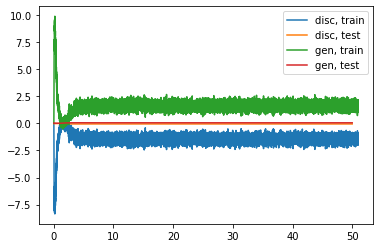

In [55]:
plt.plot(losses_train.epoch + losses_train['sample'] / len(data_train), losses_train.disc_loss, label='disc, train')
plt.plot(losses_test .epoch                                        , losses_test .disc_loss, label='disc, test' )
plt.plot(losses_train.epoch + losses_train['sample'] / len(data_train), losses_train.gen_loss , label='gen, train')
plt.plot(losses_test .epoch                                        , losses_test .gen_loss , label='gen, test' )
plt.legend();

In [56]:
fake = make_fake(torch.from_numpy(features_test).to(device)).cpu().detach().numpy()

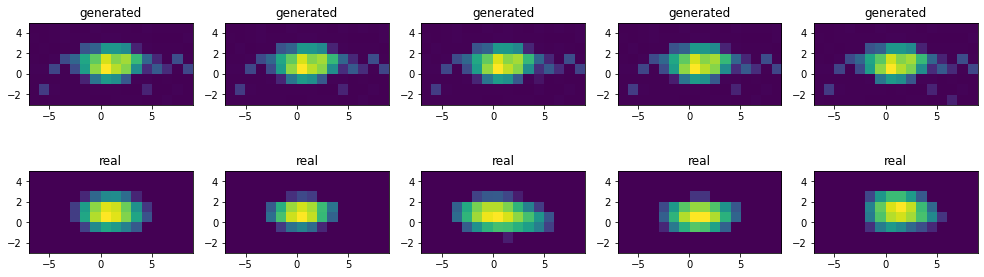

In [57]:

plt.figure(figsize=(17, 5))
for i in range(5):
  plt.subplot(2, 5, i + 1)
  plt.imshow(fake[i,::-1], extent=(*time_range, *pad_range))
  plt.title('generated')

for i in range(5):
  plt.subplot(2, 5, i + 1 + 5)
  plt.imshow(data_test[i,::-1], extent=(*time_range, *pad_range))
  plt.title('real')
plt.show();

In [58]:
def gaussian_fit(img):
    assert img.ndim == 2
    assert (img >= 0).all()
    assert (img > 0).any()
    img_n = img / img.sum()

    mu = np.fromfunction(
        lambda i, j: (img_n[np.newaxis,...] * np.stack([i, j])).sum(axis=(1, 2)),
        shape=img.shape
    )
    cov = np.fromfunction(
        lambda i, j: (
            (img_n[np.newaxis,...] * np.stack([i * i, j * i, i * j, j * j])).sum(axis=(1, 2))
        ) - np.stack([mu[0]**2, mu[0]*mu[1], mu[0]*mu[1], mu[1]**2]),
        shape=img.shape
    ).reshape(2, 2)

    return mu, cov

def get_val_metric_single(img):
    assert img.ndim == 2
    img = np.where(img < 0, 0, img)
    mu, cov = gaussian_fit(img)
    return np.array((*mu, *cov.diagonal(), cov[0, 1], img.sum()))

get_val_metric = np.vectorize(get_val_metric_single, signature='(m,n)->(k)')

In [59]:
metric_real = get_val_metric(data_test)
metric_fake = get_val_metric(fake)

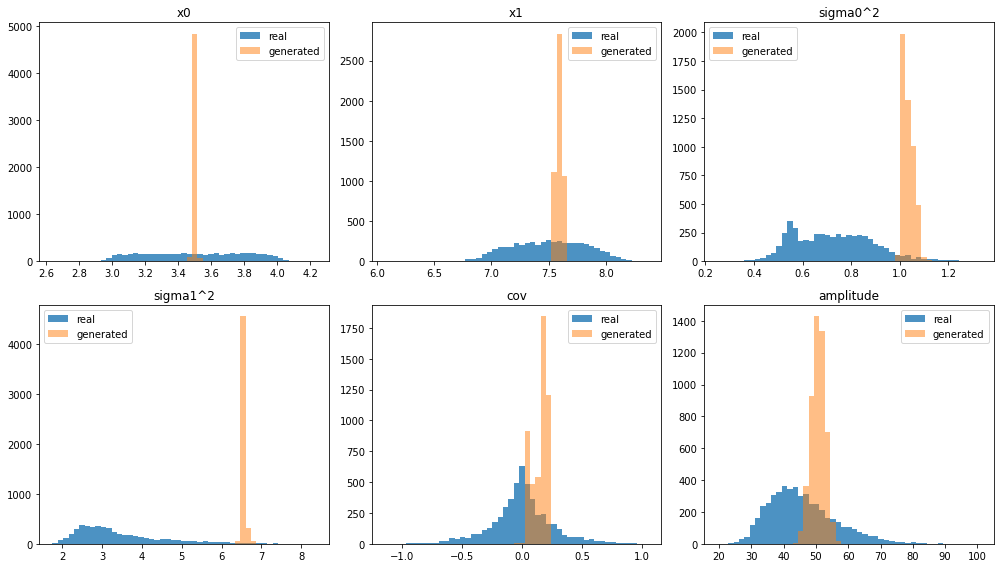

In [60]:
plt.figure(figsize=(14, 8))
labels = ['x0', 'x1', 'sigma0^2', 'sigma1^2', 'cov', 'amplitude']
for i in range(6):
    plt.subplot(2, 3, i + 1)
    r = metric_real[:,i]
    f = metric_fake[:,i]
    bins = np.linspace(
        min(r.min(), f.min()),
        max(r.max(), f.max()),
        50
    )

    plt.hist(r, bins=bins, label='real'     , alpha=0.8)
    plt.hist(f, bins=bins, label='generated', alpha=0.5)
    plt.legend()
    plt.title(labels[i])
plt.tight_layout()
plt.show();
